In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [2]:
# 根据带有噪声的线性模型构造一个人造数据集
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    # 均值为0，标准差为1，个数为num_examples，列数为len(w)的符合正态分布的随机元素组成的张量
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)  # 加随机噪声
    return X, y.reshape((-1, 1)) #  将y作为列向量返回

true_w = torch.tensor([2, -3.4])
true_b = 4.2 #  定义w，b
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
# features中的每一行都包含一个二维数据样本， 
# labels中的每一行都包含一维标签值（一个标量）。
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.3886, -2.9338]) 
label: tensor([13.4049])


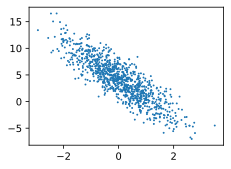

In [4]:
d2l.set_figsize()
# features[:,1]:取出列号为1的所有值（行全切片，列去1号）
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

In [5]:
# 读取数据集
# data_iter()函数接收批量大小、特征矩阵和标签向量作为输入，
# 生成大小为batch_size的小批量。 每个小批量包含一组特征和标签。
def data_iter(batch_size, features, labels):
    num_examples = len(features)  # 样本数量=features的行数
    indices = list(range(num_examples))  # 转换成列表形式
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        # 切片：从第i个切batch_size个,若不足则切到num_examples处
        yield features[batch_indices], labels[batch_indices]

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.0961, -0.8036],
        [-1.8695,  1.1508],
        [ 0.0332,  1.7060],
        [-1.1611, -1.4698],
        [ 1.9430,  1.2088],
        [-1.4141, -1.8423],
        [-0.1998,  0.0543],
        [ 0.3350, -0.8948],
        [-1.1343, -0.7478],
        [-0.3731, -0.1676]]) 
 tensor([[ 6.7315],
        [-3.4473],
        [-1.5470],
        [ 6.8963],
        [ 3.9675],
        [ 7.6418],
        [ 3.6064],
        [ 7.9074],
        [ 4.4713],
        [ 4.0329]])


In [7]:
# 初始化模型参数（随机生成权重与偏置）
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [8]:
# 定义模型
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [9]:
# 定义损失函数
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [10]:
# 定义优化算法
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [11]:
lr = 0.01
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 2.333061
epoch 2, loss 0.345523
epoch 3, loss 0.051277
epoch 4, loss 0.007652
epoch 5, loss 0.001177
epoch 6, loss 0.000219
epoch 7, loss 0.000077
epoch 8, loss 0.000056
epoch 9, loss 0.000053
epoch 10, loss 0.000052


In [12]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0005, -0.0003], grad_fn=<SubBackward0>)
b的估计误差: tensor([2.3842e-05], grad_fn=<RsubBackward1>)
